In [1]:
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)

In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from collections import Counter
import pandas as pd 
from sklearn.tree import plot_tree
import tensorflow as tf

from sklearn.ensemble import BaggingClassifier

In [3]:
#Raccourci load data 1
fraude = pd.read_table("/Volumes/KINGSTON/M2/Big data mining/Projet_BDM/dataproject.txt",sep=";",decimal=",")

fraude['FlAgImpAye'] = fraude['FlAgImpAye'].astype(str) 
fraude['CodeDecision'] = fraude['CodeDecision'].astype(str) 
fraude['IDAvisAutorisAtionCheque'] = fraude['IDAvisAutorisAtionCheque'].astype(str) 

#Variables actives originales
fraude_act = fraude.iloc[:,2:23]

#fraude2 = data avec dummy 
dummy = pd.get_dummies(fraude['CodeDecision'], prefix='Code' )
dummy

fraude2 = fraude.drop('CodeDecision',axis='columns')
fraude2 = pd.concat([fraude2,dummy],axis=1)

#Train exploitable 
fraude_train = fraude2.iloc[0:1967226]

#Test exploitable 
fraude_test = fraude2.iloc[1967226:len(fraude.index)]

#Train des variables actives exploitable 
fraude_train_act = fraude_train.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')

#Test des variables actives
fraude_test_act = fraude_test.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')

#Variables actives + cible pour les stats desc 
fraude_desc = pd.concat([fraude_train_act,fraude_train['FlAgImpAye']],axis=1)

In [4]:
fraude_train_v = fraude_train.iloc[0:1677541,:]
fraude_train_act_v = fraude_train_act.iloc[0:1677541,:]
fraude_valid = fraude_train.iloc[1677541:1967226,:]
fraude_train_v.FlAgImpAye.value_counts()

0    1673087
1       4454
Name: FlAgImpAye, dtype: int64

In [5]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

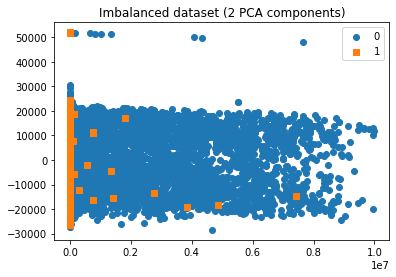

In [6]:
y=fraude_train_v['FlAgImpAye']
pca = PCA(n_components=2)
X = pca.fit_transform(fraude_train_act_v)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

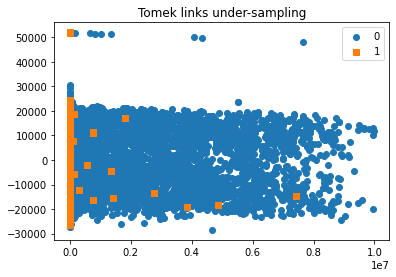

In [7]:
tl = TomekLinks(sampling_strategy="majority") #return_indices=True, ratio='majority'
X_tl, y_tl = tl.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')




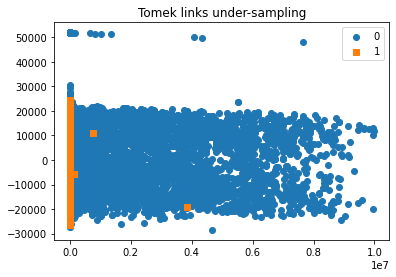

In [158]:
tl2 = TomekLinks(sampling_strategy="all") #return_indices=True, ratio='majority'
X_tl2, y_tl2 = tl2.fit_sample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl2, y_tl2, 'Tomek links under-sampling')





In [ ]:
smt = SMOTETomek(n_jobs=-1)
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [159]:

#-----------------ARBRE------------------------- !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! tl ou tl2 !!!!!

ytrain_arbre_red = fraude_train_v.iloc[tl.sample_indices_,:]
ytrain_arbre_red= ytrain_arbre_red['FlAgImpAye']
xtrain_arbre_red = fraude_train_act_v.iloc[tl.sample_indices_,:]
train_arbre_red = pd.concat([xtrain_arbre_red,ytrain_arbre_red],axis=1)

#ytest_arbre_red = ytest_keras
#xtest_arbre_red = xtest_keras
#test_arbre_red = pd.concat([xtest_arbre_red,fraude_test['FlAgImpAye']],axis=1)

yvalid_arbre = fraude_valid['FlAgImpAye']
xvalid_arbre = fraude_valid.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')
valid_arbre = fraude_valid



In [ ]:
def calcul_F(mat):
    
    TP= mat[0,0]
    FN= mat[0,1]
    FP= mat[1,0]
    #F= 2TP / 2T P + F N + F P
    F= 2*TP/(2*TP+FN+FP)
    return(F)

In [160]:

#classe bagging
from sklearn.ensemble import BaggingClassifier
#instanciation
baggingTree = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'),n_estimators=5, n_jobs=-1,random_state=1) #20
print(baggingTree)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                  n_estimators=5, n_jobs=-1, random_state=1)


In [161]:
#apprentissage
baggingTree.fit(xtrain_arbre_red,ytrain_arbre_red)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                  n_estimators=5, n_jobs=-1, random_state=1)

In [162]:
predbag = baggingTree.predict(xvalid_arbre)

In [163]:
metrics.confusion_matrix(yvalid_arbre,predbag,labels=['1','0'])

array([[    11,    937],
       [    23, 288714]])

In [164]:
metrics.roc_auc_score(yvalid_arbre,predbag)

0.5057618591307357

In [ ]:
#fonction pour évaluation de méthodes
def error_rate(modele,y_test,X_test):
#prediction
    y_pred = modele.predict(X_test)
    #taux d'erreur
    err = 1.0 - metrics.accuracy_score(y_test,y_pred)
    #return
    return err
#fin fonction

In [17]:
calcul_F(metrics.confusion_matrix(yvalid_arbre,predbag,labels=['1','0']))



0.05603864734299517

In [18]:
metrics.f1_score(yvalid_arbre,predbag,pos_label='1')

0.056038647342995164

In [165]:
baggingTree2 = BaggingClassifier(DecisionTreeClassifier(),n_estimators=10, n_jobs=-1) #20



In [166]:
baggingTree2.fit(xtrain_arbre_red,ytrain_arbre_red)



BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_jobs=-1)

In [167]:
predbag2 = baggingTree2.predict(xvalid_arbre)

In [168]:
metrics.confusion_matrix(yvalid_arbre,predbag2,labels=['1','0'])

array([[    18,    930],
       [     7, 288730]])

In [169]:
metrics.roc_auc_score(yvalid_arbre,predbag2)

0.5094815491282133

In [170]:
metrics.f1_score(yvalid_arbre,predbag2,pos_label='1')

0.03699897225077081

In [12]:
#fonction train-test pour un m donné
def train_test_bagging(m,X_app,y_app,X_test,y_test):
    #modélisation
    bag = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced',random_state=1),n_estimators=m,n_jobs=-1,random_state=1)
#prédiction
    bag.fit(X_app,y_app)
    
    pred = bag.predict(X_test)
    return metrics.f1_score(y_test,pred,pos_label='1')


In [50]:
#fin train-test
#valeurs de m à tester
#m_a_tester = [1,5,10,20,50,100,200]
m_a_tester = [1,5,10,20,50]
#initialisation de la matrice de résultat
#result = np.zeros(shape=(1,7))
result = np.zeros(shape=(1,5))
#répéter 20 fois l'expérience
for expe in range(2):  #20
#itérer sur ces valeurs
    res = [train_test_bagging(m,xtrain_arbre_red,ytrain_arbre_red,xvalid_arbre,yvalid_arbre) for m in m_a_tester]
    #le vecteur de 7 valeurs est transformé en une matrice 1 ligne et 7 colonnes
   # res = np.asarray(res).reshape(1,7)
    res = np.asarray(res).reshape(1,5)
    #ajouter comme nouvelle ligne dans la matrice
result = np.append(result,res,axis=0)
#
#retirer la première ligne de zéros
result = np.delete(result,0,axis=0)
#calculer les moyennes
mresult = np.mean(result,axis=0)
print(mresult)

[0.05       0.05603865 0.0307377  0.03089598 0.02471679]


#1 fois 
[0.05       0.05603865 0.0307377  0.03089598 0.02471679]
#2 fois  [0.05       0.05603865 0.0307377  0.03089598 0.02471679]


BAGGING +ADL

In [9]:
#analyse discriminante
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#instanciation
bag_lda2 = BaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=20,n_jobs=-1,random_state=1)
print(bag_lda2)
#apprentissage
bag_lda2.fit(xtrain_arbre_red,ytrain_arbre_red)



BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=20,
                  n_jobs=-1, random_state=1)


BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=20,
                  n_jobs=-1, random_state=1)

In [10]:
predadl2 = bag_lda2.predict(xvalid_arbre)



In [11]:
metrics.roc_auc_score(yvalid_arbre,predadl2)

0.571068974935785

In [12]:
metrics.f1_score(yvalid_arbre,predadl2,pos_label='1')

0.10416666666666667

In [13]:
metrics.confusion_matrix(yvalid_arbre,predadl2,labels=['1','0'])

array([[   140,    808],
       [  1600, 287137]])

In [14]:
from imblearn.ensemble import BalancedBaggingClassifier 

#instanciation
bag_lda3 = BalancedBaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=20,n_jobs=-1,random_state=1)

#apprentissage
bag_lda3.fit(xtrain_arbre_red,ytrain_arbre_red)


BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                          n_estimators=20, n_jobs=-1, random_state=1)

In [15]:
predadl3 = bag_lda3.predict(xvalid_arbre)



In [16]:
metrics.roc_auc_score(yvalid_arbre,predadl3)

0.736126741286133

In [17]:
metrics.f1_score(yvalid_arbre,predadl3,pos_label='1')

0.019053264459310694

In [18]:
metrics.confusion_matrix(yvalid_arbre,predadl3,labels=['1','0'])

array([[   675,    273],
       [ 69231, 219506]])

In [33]:
#instanciation
bag_lda4 = BalancedBaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=50,n_jobs=-1,random_state=1)

#apprentissage
bag_lda4.fit(xtrain_arbre_red,ytrain_arbre_red)



BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                          n_estimators=50, n_jobs=-1, random_state=1)

In [34]:
predadl4 = bag_lda4.predict(xvalid_arbre)



In [35]:
metrics.roc_auc_score(yvalid_arbre,predadl4)

0.7371432372669043

In [36]:
metrics.f1_score(yvalid_arbre,predadl4,pos_label='1')

0.01921243257859308

In [37]:
metrics.confusion_matrix(yvalid_arbre,predadl4,labels=['1','0'])

array([[   675,    273],
       [ 68644, 220093]])

In [40]:
#fonction train-test pour un m donné
def train_test_bagging2(m,X_app,y_app,X_test,y_test):
    #modélisation
    bag = BalancedBaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=m,n_jobs=-1,random_state=1)
#prédiction
    bag.fit(X_app,y_app)
    
    pred = bag.predict(X_test)
    return metrics.f1_score(y_test,pred,pos_label='1')



In [42]:
m_a_tester = [1,5,10,20,50,100,200]

#initialisation de la matrice de résultat
result = np.zeros(shape=(1,7))

#répéter 20 fois l'expérience
for expe in range(2):
#itérer sur ces valeurs
    res = [train_test_bagging2(m,xtrain_arbre_red,ytrain_arbre_red,xvalid_arbre,yvalid_arbre) for m in m_a_tester]
    #le vecteur de 7 valeurs est transformé en une matrice 1 ligne et 7 colonnes
    res = np.asarray(res).reshape(1,7)

    #ajouter comme nouvelle ligne dans la matrice
result = np.append(result,res,axis=0)
#
#retirer la première ligne de zéros
result = np.delete(result,0,axis=0)
#calculer les moyennes
mresult = np.mean(result,axis=0)
print(mresult)

[0.01870298 0.01905565 0.01904306 0.01905326 0.01921243 0.01924507
 0.01929297]


[0.01870298 0.01905565 0.01904306 0.01905326 0.01921243 0.01924507
 0.01929297]

In [92]:
#instanciation
bag_lda5 = BalancedBaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=300,n_jobs=-1,random_state=1)

#apprentissage
bag_lda5.fit(xtrain_arbre_red,ytrain_arbre_red)




BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                          n_estimators=300, n_jobs=-1, random_state=1)

In [93]:
predadl5 = bag_lda5.predict(xvalid_arbre)



In [94]:
metrics.roc_auc_score(yvalid_arbre,predadl5)

0.737365628414359

In [95]:
metrics.f1_score(yvalid_arbre,predadl5,pos_label='1')

0.019303194764652813

In [96]:
metrics.confusion_matrix(yvalid_arbre,predadl5,labels=['1','0'])

array([[   674,    274],
       [ 68211, 220526]])

In [49]:
#instanciation
bag_lda6 = BalancedBaggingClassifier(LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),n_estimators=300,n_jobs=-1,random_state=1)

#apprentissage
bag_lda6.fit(xtrain_arbre_red,ytrain_arbre_red)





BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(shrinkage='auto',
                                                                    solver='lsqr'),
                          n_estimators=300, n_jobs=-1, random_state=1)

In [50]:
predadl6 = bag_lda6.predict(xvalid_arbre)



In [51]:
metrics.roc_auc_score(yvalid_arbre,predadl6)

0.7355908741006171

In [52]:
metrics.f1_score(yvalid_arbre,predadl6,pos_label='1')

0.019299004759844224

In [53]:
metrics.confusion_matrix(yvalid_arbre,predadl6,labels=['1','0'])

array([[   669,    279],
       [ 67713, 221024]])

In [54]:
#instanciation
bag_lda7 = BaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=300,n_jobs=-1,random_state=1)

#apprentissage
bag_lda7.fit(xtrain_arbre_red,ytrain_arbre_red)




BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=300,
                  n_jobs=-1, random_state=1)

In [55]:
predadl7 = bag_lda7.predict(xvalid_arbre)



In [56]:
print (metrics.roc_auc_score(yvalid_arbre,predadl7)," - ",metrics.f1_score(yvalid_arbre,predadl7,pos_label='1'))

0.5720268531935586  -  0.10342316096139839


In [57]:
metrics.confusion_matrix(yvalid_arbre,predadl7,labels=['1','0'])

array([[   142,    806],
       [  1656, 287081]])

In [58]:
metrics.confusion_matrix(yvalid_arbre,predadl5,labels=['1','0'])

array([[   674,    274],
       [ 68211, 220526]])

In [52]:
metrics.roc_auc_score(yvalid_arbre,predrf)

0.5226291061833693

In [53]:
metrics.f1_score(yvalid_arbre,predrf,pos_label='1')

0.08431372549019608

In [47]:
#classe RandomForest
from sklearn.ensemble import RandomForestClassifier
#instanciation
rf = RandomForestClassifier(n_estimators=5, n_jobs=-1,random_state=1)

In [48]:
rf.fit(xtrain_arbre_red,ytrain_arbre_red)

RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=1)

In [50]:
predrf= rf.predict(xvalid_arbre)

In [51]:
metrics.confusion_matrix(yvalid_arbre,predrf,labels=['1','0'])

array([[    43,    905],
       [    29, 288708]])

AFD

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#instanciation
lda = LinearDiscriminantAnalysis()

#apprentissage
lda.fit(fraude_train_act_v,fraude_train_v['FlAgImpAye'])

LinearDiscriminantAnalysis()

In [39]:


#dimensions
print(lda.coef_.shape)

(1, 21)


In [40]:
print(lda.classes_)

['0' '1']


In [41]:
#projection dans l'espace facoriel
Fact = lda.transform(xtrain_arbre_red)
print(Fact[:5,:])

[[-1.00528998]
 [-0.63575686]
 [-0.10109758]
 [ 0.30633191]
 [ 0.33147791]]


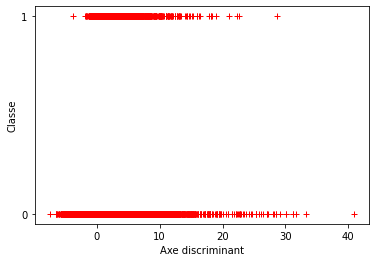

In [34]:
plt.plot(Fact, ytrain_arbre_red, 'r+')
plt.xlabel("Axe discriminant")
plt.ylabel("Classe")
plt.yticks([0, 1])
plt.show()

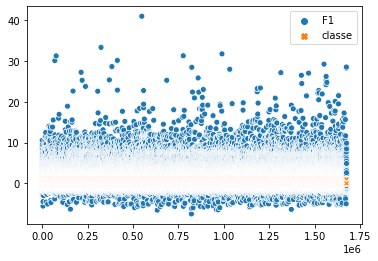

In [37]:
#data frame pour représentation graphique
dfFact = pd.DataFrame(Fact,columns=['F1']) 
dfFact['classe'] = ytrain_arbre_red
#représentation graphique
import seaborn as sns 
sns.scatterplot(hue="classe",data=dfFact)

In [44]:
#instanciation
ldabagunder = BaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=20)

#apprentissage
ldabagunder.fit(X_under,y_under)



BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=20)

In [45]:
#évaluation
predldabagunder = ldabagunder.predict(xvalid_arbre)




In [46]:
metrics.roc_auc_score(yvalid_arbre,predldabagunder)

0.7371142754720109

In [47]:
metrics.f1_score(yvalid_arbre,predldabagunder,pos_label='1')

0.019375207231104127

In [48]:
metrics.confusion_matrix(yvalid_arbre,predldabagunder,labels=['1','0'])

array([[   672,    276],
       [ 67747, 220990]])

CLUSTER

In [10]:
#k-means sur les données centrées et réduites
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(xtrain_arbre_red)

KMeans(n_clusters=2)

In [11]:
#index triés des groupes
idk = np.argsort(kmeans.labels_)

In [12]:
pd.crosstab(ytrain_arbre_red,kmeans.labels_)

col_0,0,1
FlAgImpAye,,
0,1668709,1818
1,4450,4


In [16]:
#metrics.silhouette_score(xtrain_arbre_red,kmeans.labels_)

In [17]:
kmeans3 = cluster.KMeans(n_clusters=3)
kmeans3.fit(xtrain_arbre_red)
pd.crosstab(ytrain_arbre_red,kmeans3.labels_)

col_0,0,1,2
FlAgImpAye,,,
0,1668110,896,1521
1,4449,2,3


In [18]:
kmeans4 = cluster.KMeans(n_clusters=4)
kmeans4.fit(xtrain_arbre_red)
pd.crosstab(ytrain_arbre_red,kmeans4.labels_)

col_0,0,1,2,3
FlAgImpAye,,,,
0,1666701,1088,773,1965
1,4444,3,1,6


In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#instanciation
bag_lda_clust = BaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=20)

#apprentissage
bag_lda_clust.fit(xtrain_arbre_red[kmeans.labels_ ==0],ytrain_arbre_red[kmeans.labels_ ==0])



BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=20)

In [22]:
ytrain_arbre_red[kmeans.labels_ ==0].value_counts()

0    1668709
1       4450
Name: FlAgImpAye, dtype: int64

In [23]:
predadlclust = bag_lda_clust.predict(xvalid_arbre)



In [24]:
print (metrics.roc_auc_score(yvalid_arbre,predadlclust)," - ",metrics.f1_score(yvalid_arbre,predadlclust,pos_label='1'))


0.5716067911742906  -  0.10510622437569883


In [25]:
metrics.confusion_matrix(yvalid_arbre,predadlclust,labels=['1','0'])

array([[   141,    807],
       [  1594, 287143]])

In [31]:
print (metrics.roc_auc_score(yvalid_arbre,predadl)," - ",metrics.f1_score(yvalid_arbre,predadl,pos_label='1'))



0.5709893176698302  -  0.10241404535479151


In [46]:
from imblearn.ensemble import BalancedBaggingClassifier 


#instanciation
bag_lda_clust2 = BalancedBaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=2,random_state=1)

#apprentissage
bag_lda_clust2.fit(xtrain_arbre_red[kmeans.labels_ ==0],ytrain_arbre_red[kmeans.labels_ ==0])




BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                          n_estimators=2, random_state=1)

In [47]:
predadlclust2 = bag_lda_clust2.predict(xvalid_arbre)



In [48]:
print (metrics.roc_auc_score(yvalid_arbre,predadlclust2)," - ",metrics.f1_score(yvalid_arbre,predadlclust2,pos_label='1'))



0.7372998245859617  -  0.019292696540767987


In [49]:
metrics.confusion_matrix(yvalid_arbre,predadlclust2,labels=['1','0'])

array([[   674,    274],
       [ 68249, 220488]])

In [73]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# define the base models
level0 = list()
level0.append(('lda1', bag_lda_clust))
level0.append(('lda2', bag_lda_clust2))
              
# define meta learner model
level1 = LogisticRegression()              

In [74]:
# define the stacking ensemble
modelstack = StackingClassifier(estimators=level0, final_estimator=level1, n_jobs=-1,verbose=2)

In [75]:
# fit the model on all available data
modelstack.fit(xtrain_arbre_red, ytrain_arbre_red)

KeyboardInterrupt: 

In [70]:
predstack=modelstack.predict(xvalid_arbre)

In [71]:
print (metrics.roc_auc_score(yvalid_arbre,predstack)," - ",metrics.f1_score(yvalid_arbre,predstack,pos_label='1'))



0.5  -  0.0


In [72]:
metrics.confusion_matrix(yvalid_arbre,predstack,labels=['1','0'])

array([[     0,    948],
       [     0, 288737]])

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
http://eric.univ-lyon2.fr/~ricco/cours/slides/stacking

In [77]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Users/Anthony/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xn/b9h4hj6d5bb2ls51bhk2jhxw0000gn/T/tmpric59u_g
  JVM stdout: /var/folders/xn/b9h4hj6d5bb2ls51bhk2jhxw0000gn/T/tmpric59u_g/h2o_Anthony_started_from_python.out
  JVM stderr: /var/folders/xn/b9h4hj6d5bb2ls51bhk2jhxw0000gn/T/tmpric59u_g/h2o_Anthony_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_Anthony_vygv1y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [82]:
hxtrain = h2o.H2OFrame(xtrain_arbre_red) 
hytrain = h2o.H2OFrame(pd.DataFrame(ytrain_arbre_red))
hxvalid = h2o.H2OFrame(xvalid_arbre)
hyvalid = h2o.H2OFrame(pd.DataFrame(yvalid_arbre))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
htrain = h2o.H2OFrame(fraude_train_v.iloc[tl.sample_indices_,:])
hvalid= h2o.H2OFrame(fraude_valid)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [86]:
# Identify predictors and response
x = htrain.columns
y = "FlAgImpAye"
x.remove(y)

In [88]:
# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(
                                      seed=1)
my_gbm.train(x, y,htrain)


/Users/Anthony/opt/anaconda3/lib/python3.8/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [ZIBZIN]
  warnings.warn(mesg["message"], RuntimeWarning)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [91]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 seed=1)
my_rf.train(x, y,htrain)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [94]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
#ensemble.train(x=x, y=y, training_frame=htrain)


In [95]:
ensemble.train(x,y,htrain)


stackedensemble Model Build progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_8cf1feef06e2aab450939bb86976476a failed with an exception: water.exceptions.H2OIllegalArgumentException: Base model does not use cross-validation: 0
stacktrace: 
water.exceptions.H2OIllegalArgumentException: Base model does not use cross-validation: 0
	at hex.ensemble.StackedEnsembleModel.checkAndInheritModelProperties(StackedEnsembleModel.java:517)
	at hex.ensemble.StackedEnsemble$StackedEnsembleDriver.computeImpl(StackedEnsemble.java:335)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:243)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1575)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [ ]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(hvalid)

In [97]:
perf_gbm_test = my_gbm.model_performance(hvalid)
perf_rf_test = my_rf.model_performance(hvalid)

In [100]:
perf_gbm_test.auc()

KeyError: 'AUC'

In [14]:
#utilisation de la métrique "silhouette"
#faire varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(xtrain_arbre_red)
    res[k] = metrics.silhouette_score(xtrain_arbre_red,km.labels_)
print(res)

KeyboardInterrupt: 

In [ ]:
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

In [42]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler()#sampling_strategy='majority'

In [43]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(fraude_train_act_v, fraude_train_v['FlAgImpAye'])

In [13]:
#ytrain_arbre_red = fraude_train_v.iloc[tl.sample_indices_,:]
#ytrain_arbre_red= ytrain_arbre_red['FlAgImpAye']
#xtrain_arbre_red = fraude_train_act_v.iloc[tl.sample_indices_,:]
#train_arbre_red = pd.concat([xtrain_arbre_red,ytrain_arbre_red],axis=1)

#yvalid_arbre = fraude_valid['FlAgImpAye']
#xvalid_arbre = fraude_valid.drop(['ZIBZIN','IDAvisAutorisAtionCheque','DAteTrAnsAction','FlAgImpAye'],axis='columns')
#valid_arbre = fraude_valid

ytrain_nn_tl = np.array(ytrain_arbre_red, dtype="uint8")
xtrain_nn_tl = xtrain_arbre_red
yvalid_nn = np.array(yvalid_arbre, dtype="uint8")
xvalid_nn = xvalid_arbre
valid_nn = valid_arbre



In [14]:
counts = np.bincount(ytrain_nn_tl)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(ytrain_nn_tl)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 4454 (0.27% of total)


In [15]:
#Normalisation des donénes 


mean = np.mean(xtrain_nn_tl, axis=0)
xtrain_nn_tl -= mean
xvalid_nn -= mean
std = np.std(xtrain_nn_tl, axis=0)
xtrain_nn_tl /= std
xvalid_nn /= std

In [16]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( alpha=1e-5,
                    hidden_layer_sizes=(15, 5), random_state=1,activation='tanh')





In [17]:
clf.fit(xtrain_nn_tl, ytrain_nn_tl)

MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(15, 5),
              random_state=1)

In [18]:
clfpred=clf.predict(xvalid_nn)

In [19]:
print(metrics.confusion_matrix(yvalid_nn,clfpred,labels=[1, 0]))

[[    26    922]
 [     7 288730]]


In [20]:
print(metrics.roc_auc_score(yvalid_nn,clfpred))

0.5137009584109137


In [21]:
calcul_F(metrics.confusion_matrix(yvalid_nn,clfpred,labels=[1, 0]))

0.053007135575942915

--------------------------------- RANDOM UNDER SAMPLING --------------------------------------

In [23]:
ytrain_nn_tl2 = np.array(y_under, dtype="uint8")
xtrain_nn_tl2 = X_under

yvalid_nn2 = np.array(yvalid_arbre, dtype="uint8")
xvalid_nn2 = xvalid_arbre
valid_nn2 = valid_arbre





In [24]:
#Normalisation des donénes 


mean2 = np.mean(xtrain_nn_tl2, axis=0)
xtrain_nn_tl2 -= mean2
xvalid_nn2 -= mean2
std2 = np.std(xtrain_nn_tl2, axis=0)
xtrain_nn_tl2 /= std2
xvalid_nn2 /= std2

In [68]:
clf2 = MLPClassifier( alpha=1e-5,
                    hidden_layer_sizes=(15, 5), 
                     random_state=1,
                     activation='tanh',
                     max_iter=500,
                    learning_rate='adaptive')


#augmentation de maxiter car pas convegé sinon 



In [69]:
clf2.fit(xtrain_nn_tl2, ytrain_nn_tl2)

MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(15, 5),
              learning_rate='adaptive', max_iter=500, random_state=1)

In [70]:
clfpred2=clf2.predict(xvalid_nn2)

In [71]:
print(metrics.confusion_matrix(yvalid_nn2,clfpred2,labels=[1, 0]))

[[   761    187]
 [184062 104675]]


In [72]:
print(metrics.roc_auc_score(yvalid_nn2,clfpred2))

0.5826348800564847


In [58]:
calcul_F(metrics.confusion_matrix(yvalid_nn2,clfpred2,labels=[1, 0]))

0.008192882635072212

In [59]:
bc = BaggingClassifier(base_estimator=clf2, n_estimators=300, n_jobs=-1) #
# Fit 'bc' to the training set
bc.fit(xtrain_nn_tl2, ytrain_nn_tl2)

BaggingClassifier(base_estimator=MLPClassifier(activation='tanh', alpha=1e-05,
                                               hidden_layer_sizes=(15, 5),
                                               max_iter=500, random_state=1),
                  n_estimators=300, n_jobs=-1)

In [60]:
bcpred=bc.predict(xvalid_nn)

In [62]:
print(metrics.confusion_matrix(yvalid_nn2,bcpred,labels=[1, 0]))

[[   943      5]
 [288487    250]]


In [63]:
calcul_F(metrics.confusion_matrix(yvalid_nn2,bcpred,labels=[1, 0]))

0.0064949824022481045

MERCREDI 20

In [21]:
from sklearn.ensemble import VotingClassifier 

clf_voting = VotingClassifier(estimators=[ ('lda2', bag_lda2), 
                                          ('lda3', bag_lda3)],  
                              voting='soft') #, weights=[w_1, w_2, ..., w_N]

In [22]:
# Fit it to the training set and predict
clf_voting.fit(xtrain_arbre_red, ytrain_arbre_red)


VotingClassifier(estimators=[('lda2',
                              BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                n_estimators=20, n_jobs=-1,
                                                random_state=1)),
                             ('lda3',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=20,
                                                        n_jobs=-1,
                                                        random_state=1))],
                 voting='soft')

In [23]:
clf_pred = clf_voting.predict(xvalid_arbre)

In [24]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred)," - ",metrics.f1_score(yvalid_arbre,clf_pred,pos_label='1'))

0.6021782426239323  -  0.09532710280373832


In [25]:
metrics.confusion_matrix(yvalid_arbre,clf_pred,labels=['1','0'])

array([[   204,    744],
       [  3128, 285609]])

In [26]:
metrics.confusion_matrix(yvalid_arbre,predadl2,labels=['1','0'])

array([[   140,    808],
       [  1600, 287137]])

In [27]:
metrics.confusion_matrix(yvalid_arbre,predadl3,labels=['1','0'])

array([[   675,    273],
       [ 69231, 219506]])

In [38]:
clf_voting2 = VotingClassifier(estimators=[ ('lda2', bag_lda2), 
                                          ('lda3', bag_lda3)], 
                               weights=[1.7, 2],
                              voting='soft') #, weights=[w_1, w_2, ..., w_N]
#1,2 --> pas ouf 
#1,5 2 -->un peu mieux 0.64  0.07


In [39]:
clf_voting2.fit(xtrain_arbre_red, ytrain_arbre_red)



VotingClassifier(estimators=[('lda2',
                              BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                n_estimators=20, n_jobs=-1,
                                                random_state=1)),
                             ('lda3',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=20,
                                                        n_jobs=-1,
                                                        random_state=1))],
                 voting='soft', weights=[1.7, 2])

In [40]:
clf_pred2 = clf_voting2.predict(xvalid_arbre)

In [41]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred2)," - ",metrics.f1_score(yvalid_arbre,clf_pred2,pos_label='1'))

0.6179547908555446  -  0.0856269113149847


In [42]:
metrics.confusion_matrix(yvalid_arbre,clf_pred2,labels=['1','0'])

array([[   238,    710],
       [  4373, 284364]])

ADL basique

In [43]:
adl = LinearDiscriminantAnalysis()

adl.fit(xtrain_arbre_red, ytrain_arbre_red)

LinearDiscriminantAnalysis()

In [46]:
predadlc = adl.predict(xvalid_arbre)

In [59]:
print(np.unique(predadlc,return_counts=True))

(array(['0', '1'], dtype='<U1'), array([287885,   1800]))


In [61]:
print(np.unique(yvalid_arbre,return_counts=True))

(array(['0', '1'], dtype=object), array([288737,    948]))


In [63]:
proba = adl.predict_proba(xtrain_arbre_red)
print(proba[:15,:])

[[9.99916526e-01 8.34744426e-05]
 [9.99836702e-01 1.63298274e-04]
 [9.99568984e-01 4.31015595e-04]
 [9.99097239e-01 9.02760590e-04]
 [9.99055075e-01 9.44924771e-04]
 [9.99879802e-01 1.20197739e-04]
 [9.99906636e-01 9.33638561e-05]
 [9.99769634e-01 2.30365909e-04]
 [9.99917962e-01 8.20379839e-05]
 [9.99165654e-01 8.34345817e-04]
 [9.99922924e-01 7.70756615e-05]
 [4.26727628e-04 9.99573272e-01]
 [9.99747397e-01 2.52602679e-04]
 [9.99703370e-01 2.96630273e-04]
 [9.99910271e-01 8.97288397e-05]]


In [69]:
predadlctrain= adl.predict(xtrain_arbre_red)

In [71]:
predadlctrain[:15]

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0'], dtype='<U1')

In [75]:
d = {'train': pd.to_numeric(ytrain_arbre_red), 'pred': pd.to_numeric(predadlctrain)}
df = pd.DataFrame(data=d)

In [76]:
df['diff']= df.train-df.pred

In [81]:
df[df['diff']==0]

,train,pred,diff
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1677536,0,0,0
1677537,0,0,0
1677538,0,0,0
1677539,0,0,0


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674981 entries, 0 to 1677540
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   train   1674981 non-null  int64
 1   pred    1674981 non-null  int64
 2   diff    1674981 non-null  int64
dtypes: int64(3)
memory usage: 51.1 MB


In [88]:
xtrain_arbre_red[df['diff']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662019 entries, 0 to 1677540
Data columns (total 21 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   MontAnt         1662019 non-null  float64
 1   VerifiAnceCPT1  1662019 non-null  int64  
 2   VerifiAnceCPT2  1662019 non-null  int64  
 3   VerifiAnceCPT3  1662019 non-null  int64  
 4   D2CB            1662019 non-null  int64  
 5   ScoringFP1      1662019 non-null  float64
 6   ScoringFP2      1662019 non-null  float64
 7   ScoringFP3      1662019 non-null  float64
 8   TAuxImpNb_RB    1662019 non-null  float64
 9   TAuxImpNB_CPM   1662019 non-null  float64
 10  EcArtNumCheq    1662019 non-null  int64  
 11  NbrMAgAsin3J    1662019 non-null  int64  
 12  DiffDAteTr1     1662019 non-null  float64
 13  DiffDAteTr2     1662019 non-null  float64
 14  DiffDAteTr3     1662019 non-null  float64
 15  CA3TRetMtt      1662019 non-null  float64
 16  CA3TR           1662019 non-null  fl

In [90]:
print(np.unique(ytrain_arbre_red[df['diff']==0],return_counts=True))

(array(['0', '1'], dtype=object), array([1661433,     586]))


In [91]:
print(np.unique(ytrain_arbre_red,return_counts=True))

(array(['0', '1'], dtype=object), array([1670527,    4454]))


In [104]:
clf_voting3 = VotingClassifier(estimators=[ ('lda2', bag_lda2), 
                                          ('lda5', bag_lda5)], 
                               weights=[1.7, 2],
                              voting='soft') #, weights=[w_1, w_2, ..., w_N]

In [105]:
clf_voting3.fit(xtrain_arbre_red, ytrain_arbre_red)



VotingClassifier(estimators=[('lda2',
                              BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                n_estimators=20, n_jobs=-1,
                                                random_state=1)),
                             ('lda5',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=300,
                                                        n_jobs=-1,
                                                        random_state=1))],
                 voting='soft', weights=[1.7, 2])

In [106]:
clf_pred3 = clf_voting3.predict(xvalid_arbre)

In [107]:
metrics.confusion_matrix(yvalid_arbre,clf_pred3,labels=['1','0'])

array([[   235,    713],
       [  4287, 284450]])

In [108]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred3)," - ",metrics.f1_score(yvalid_arbre,clf_pred3,pos_label='1'))

0.6165214368282735  -  0.08592321755027423


In [102]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred2)," - ",metrics.f1_score(yvalid_arbre,clf_pred2,pos_label='1'))

0.6179547908555446  -  0.0856269113149847


In [103]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred)," - ",metrics.f1_score(yvalid_arbre,clf_pred,pos_label='1'))

0.6021782426239323  -  0.09532710280373832


In [110]:
clf_voting4 = VotingClassifier(estimators=[ ('lda2', bag_lda2), 
                                           ('lda3', bag_lda3),
                                          ('lda5', bag_lda5)], 
                               voting='soft')

In [111]:
clf_voting4.fit(xtrain_arbre_red, ytrain_arbre_red)



VotingClassifier(estimators=[('lda2',
                              BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                n_estimators=20, n_jobs=-1,
                                                random_state=1)),
                             ('lda3',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=20,
                                                        n_jobs=-1,
                                                        random_state=1)),
                             ('lda5',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=300,
                                                        n_jobs=-1,
                                                        random_state=1))],
                 vo

In [112]:
clf_pred4 = clf_voting4.predict(xvalid_arbre)

In [113]:
metrics.confusion_matrix(yvalid_arbre,clf_pred4,labels=['1','0'])

array([[   437,    511],
       [ 16238, 272499]])

In [114]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred4)," - ",metrics.f1_score(yvalid_arbre,clf_pred4,pos_label='1'))

0.7023662171854552  -  0.04959428020200874


In [132]:
clf_voting5 = VotingClassifier(estimators=[ ('lda2', bag_lda2), 
                                           ('lda3', bag_lda3),
                                          ('lda5', bag_lda5)],
                            
                              n_jobs=-1)

In [133]:
clf_voting5.fit(xtrain_arbre_red, ytrain_arbre_red)



VotingClassifier(estimators=[('lda2',
                              BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                n_estimators=20, n_jobs=-1,
                                                random_state=1)),
                             ('lda3',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=20,
                                                        n_jobs=-1,
                                                        random_state=1)),
                             ('lda5',
                              BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                        n_estimators=300,
                                                        n_jobs=-1,
                                                        random_state=1))],
                 n_

In [134]:
clf_pred5 = clf_voting5.predict(xvalid_arbre)

In [135]:
metrics.confusion_matrix(yvalid_arbre,clf_pred5,labels=['1','0'])

array([[   673,    275],
       [ 68096, 220641]])

In [127]:
print (metrics.roc_auc_score(yvalid_arbre,clf_pred5)," - ",metrics.f1_score(yvalid_arbre,clf_pred5,pos_label='1'))

0.7370373454189085  -  0.019306625356799632


pas de poids  : 
array([[   673,    275],
       [ 68096, 220641]])
       
 0.7370373454189085  -  0.019306625356799632      

In [145]:
#avent:  pip install mlxtend  
from mlxtend.classifier import StackingClassifier

 # Instantiate the 1st-layer classifiers
clf1 = BaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=20,n_jobs=-1,random_state=1)
clf3 = BalancedBaggingClassifier(LinearDiscriminantAnalysis(),n_estimators=300,n_jobs=-1,random_state=1)

In [138]:
from sklearn.linear_model import LogisticRegression
# Instantiate the 2nd-layer classifier
clf_meta = LogisticRegression()

In [146]:
# Build the Stacking classifier
clf_stack = StackingClassifier(
   classifiers=[clf1,clf3],
   meta_classifier=clf_meta,
   use_probas=False,
   use_features_in_secondary=True)

In [148]:
clf_stack.fit(xtrain_arbre_red, ytrain_arbre_red)

/Users/Anthony/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(classifiers=[BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                  n_estimators=20, n_jobs=-1,
                                                  random_state=1),
                                BalancedBaggingClassifier(base_estimator=LinearDiscriminantAnalysis(),
                                                          n_estimators=300,
                                                          n_jobs=-1,
                                                          random_state=1)],
                   meta_classifier=LogisticRegression(),
                   use_features_in_secondary=True)

In [149]:
predstack = clf_stack.predict(xvalid_arbre)

In [150]:
metrics.confusion_matrix(yvalid_arbre,predstack,labels=['1','0'])

array([[     0,    948],
       [    22, 288715]])